In [1]:
import cv2
image = cv2.imread('image.png')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

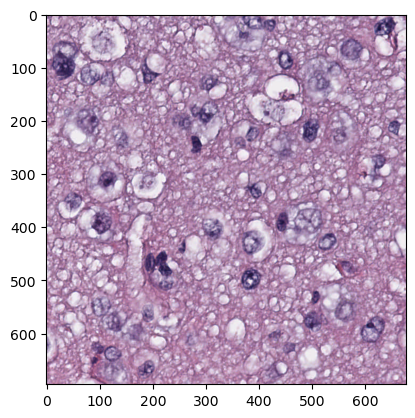

In [2]:
import matplotlib.pyplot as plt
plt.imshow(image)

## APPROACH 1 - Extracted the White hotspots around the nucleus

In [40]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.segmentation import watershed as skwater

def ShowImage(title,img,ctype):
  if ctype=='bgr':
    b,g,r = cv2.split(img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(rgb_img)
  elif ctype=='hsv':
    rgb = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    plt.imshow(rgb)
  elif ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.title(title)
  plt.show()


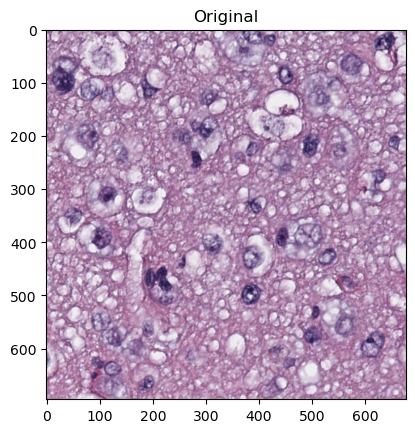

In [41]:
img = cv2.imread('image.png')
ShowImage('Original',img,'bgr')

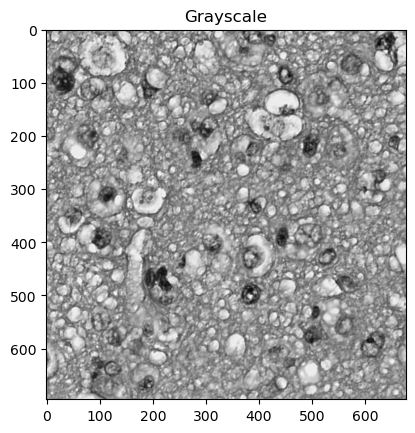

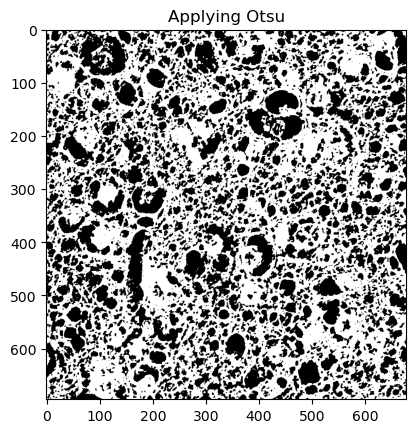

In [42]:
#Convert to a single, grayscale channel
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#Threshold the image to binary using Otsu's method
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
ShowImage('Grayscale',gray,'gray')
ShowImage('Applying Otsu',thresh,'gray')

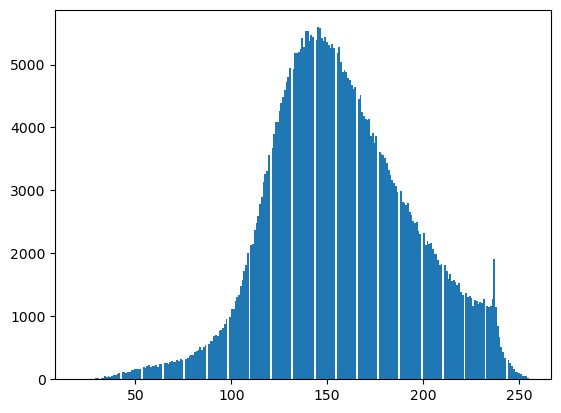

In [43]:
#Make a histogram of the intensities in the grayscale image
plt.hist(gray.ravel(),256)
plt.show()


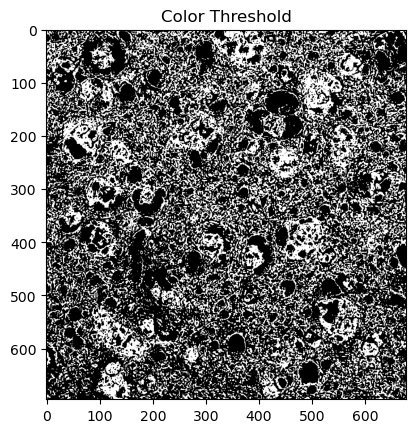

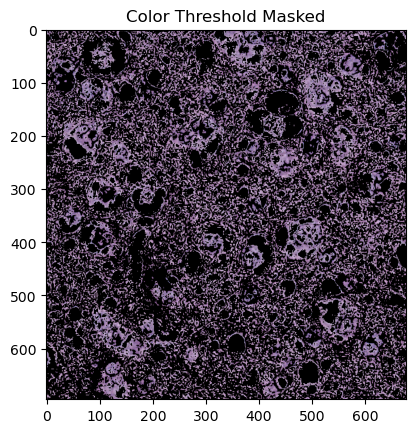

In [44]:
cell_hsvmin  = (110,40,145)  #Lower end of the HSV range defining the nuclei
cell_hsvmax  = (150,190,255) #Upper end of the HSV range defining the nuclei
#Transform image to HSV color space
hsv          = cv2.cvtColor(img,cv2.COLOR_BGR2HSV) 
#Threshold based on HSV values
color_thresh = cv2.inRange(hsv, cell_hsvmin, cell_hsvmax) 
ShowImage('Color Threshold',color_thresh,'gray')

masked = cv2.bitwise_and(img,img, mask=color_thresh)
ShowImage('Color Threshold Masked',masked,'bgr')

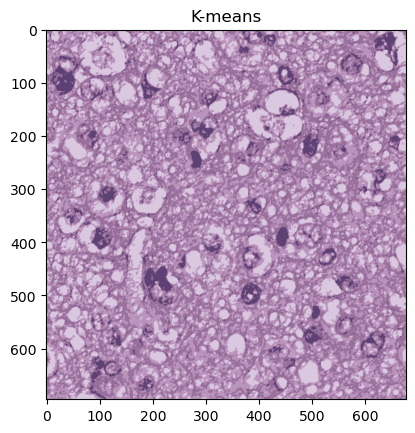

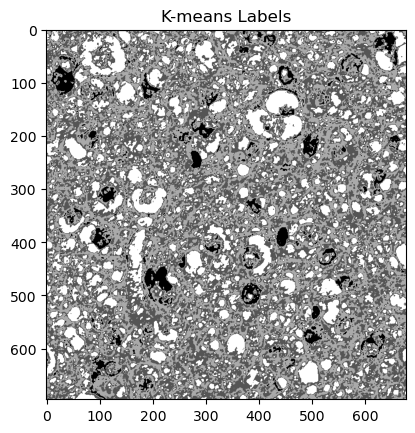

In [45]:
#Convert pixel space to an array of triplets. These are vectors in 3-space.
Z = hsv.reshape((-1,3)) 
#Convert to floating point
Z = np.float32(Z)
#Define the K-means criteria, these are not too important
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
#Define the number of clusters to find
K = 4
#Perform the k-means transformation. What we get back are:
#*Centers: The coordinates at the center of each 3-space cluster
#*Labels: Numeric labels for each cluster
#*Ret: A return code indicating whether the algorithm converged, &c.
ret,label,center = cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

#Produce an image using only the center colours of the clusters
center = np.uint8(center)
khsv   = center[label.flatten()]
khsv   = khsv.reshape((img.shape))
ShowImage('K-means',khsv,'hsv')

#Reshape labels for masking
label = label.reshape(img.shape[0:2])
ShowImage('K-means Labels',label,'gray')


In [46]:
#(Distance,Label) pairs
nucleus_colour = np.array([139, 106, 192])
cell_colour    = np.array([130, 41,  207])
nuclei_label  = (np.inf,-1)
cell_label    = (np.inf,-1)
for l,c in enumerate(center):
  print(l,c)
  dist_nuc = np.sum(np.square(c-nucleus_colour)) #Euclidean distance between colours
  if dist_nuc<nuclei_label[0]:
        nuclei_label=(dist_nuc,l)
  dist_cell = np.sum(np.square(c-cell_colour)) #Euclidean distance between colours
  if dist_cell<cell_label[0]:
        cell_label=(dist_cell,l)
nuclei_label = nuclei_label[1]
cell_label   = cell_label[1]
print("Nuclei label={0}, cell label={1}".format(nuclei_label,cell_label))

0 [136 112 117]
1 [149  53 188]
2 [148  72 156]
3 [143  27 224]
Nuclei label=2, cell label=3


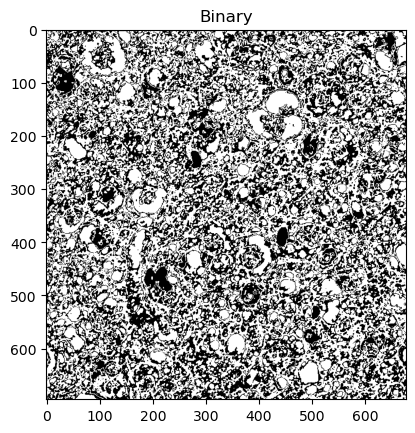

In [17]:
#Multiply by 1 to keep image in an integer format suitable for OpenCV
thresh = cv2.bitwise_or(1*(label==nuclei_label),1*(label==cell_label))
thresh = np.uint8(thresh)
ShowImage('Binary',thresh,'gray')


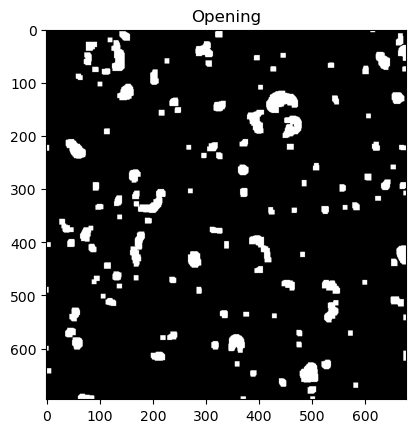

In [25]:
#Remove noise by eliminating single-pixel patches
kernel  = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel, iterations = 2)
ShowImage('Opening',opening,'gray')

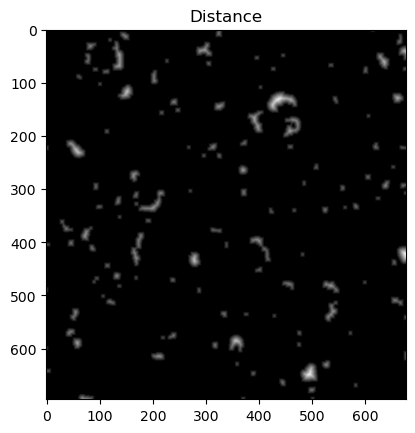

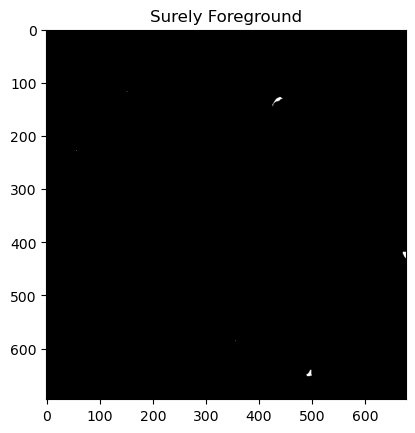

In [26]:
#Identify areas which are surely foreground
fraction_foreground = 0.75
dist         = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist,fraction_foreground*dist.max(),255,0)
ShowImage('Distance',dist,'gray')
ShowImage('Surely Foreground',sure_fg,'gray')

Peaks found: 373


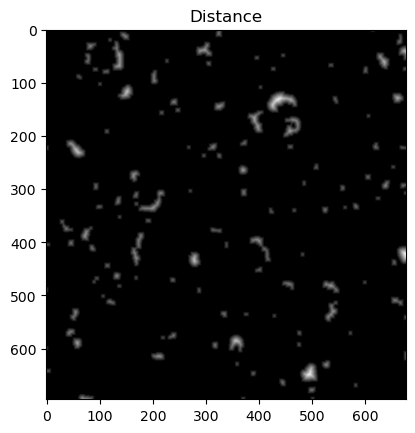

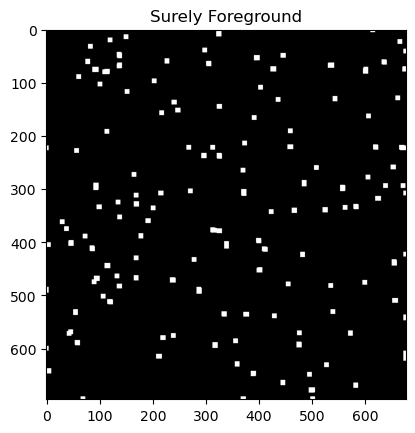

In [27]:
#Identify areas which are surely foreground
h_fraction = 0.1
dist     = cv2.distanceTransform(opening,cv2.DIST_L2,5)
maxima   = extrema.h_maxima(dist, h_fraction*dist.max())
print("Peaks found: {0}".format(np.sum(maxima)))
#Dilate the maxima so we can see them
maxima   = cv2.dilate(maxima, kernel, iterations=2)
ShowImage('Distance',dist,'gray')
ShowImage('Surely Foreground',maxima,'gray')


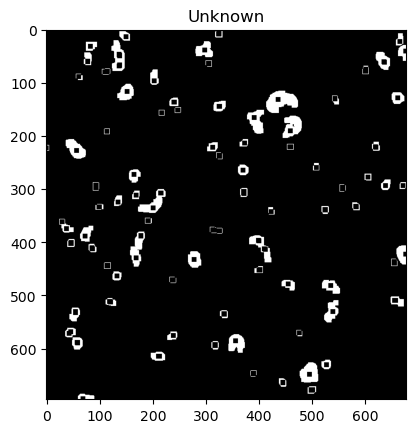

In [28]:
# Finding unknown region
unknown = cv2.subtract(opening,maxima)
ShowImage('Unknown',unknown,'gray')

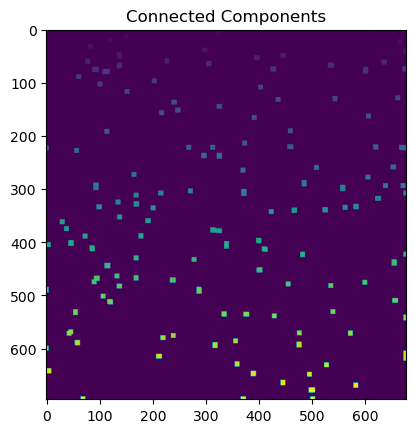

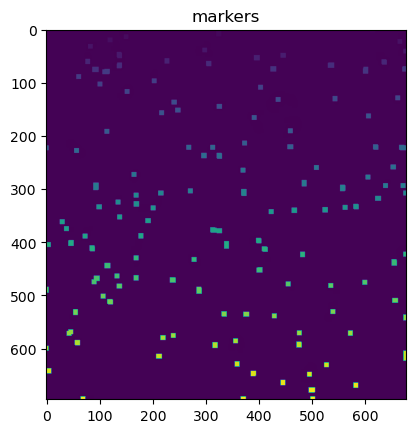

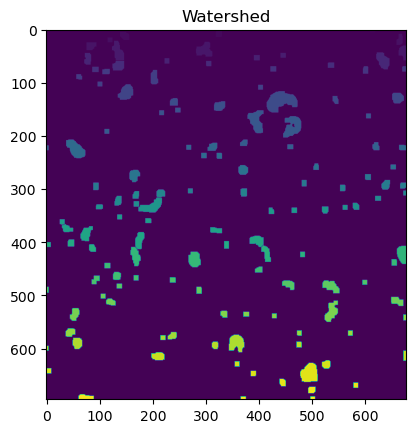

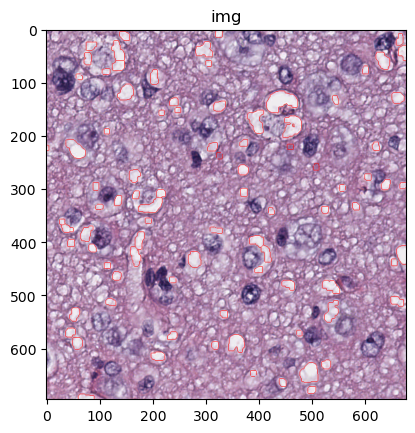

In [29]:
# Marker labelling
ret, markers = cv2.connectedComponents(maxima)
ShowImage('Connected Components',markers,'rgb')

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==np.max(unknown)] = 0

ShowImage('markers',markers,'rgb')

dist    = cv2.distanceTransform(opening,cv2.DIST_L2,5)
markers = skwater(-dist,markers,watershed_line=True)

ShowImage('Watershed',markers,'rgb')
imgout = img.copy()
imgout[markers == 0] = [0,0,255] #Label the watershed_line

ShowImage('img',imgout,'bgr')


### APPROACH 2 - USING THE WATERSHED ALGORITHM

In [31]:
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt


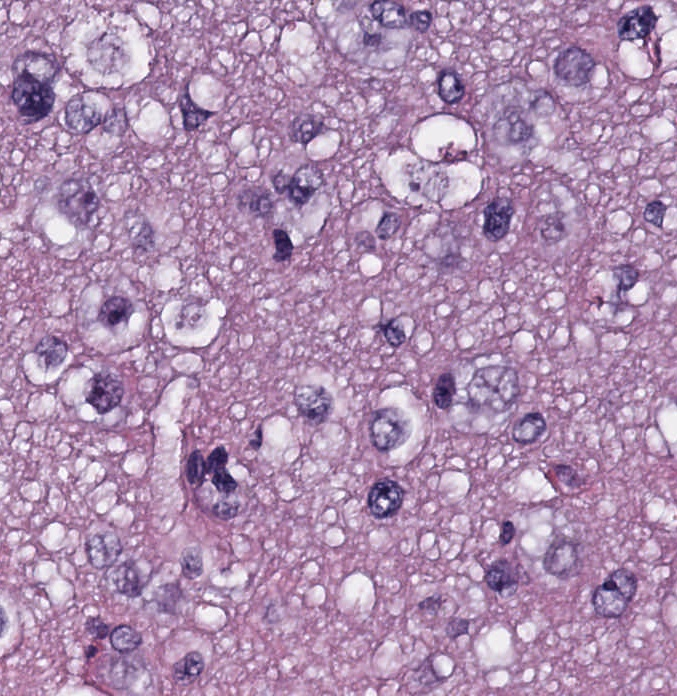

In [47]:
# Plot the image
def imshow(img, ax=None):
    if ax is None:
        ret, encoded = cv2.imencode(".jpg", img)
        display(Image(encoded))
    else:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')

#Image loading
img = cv2.imread("image.png")
# Show image
imshow(img)


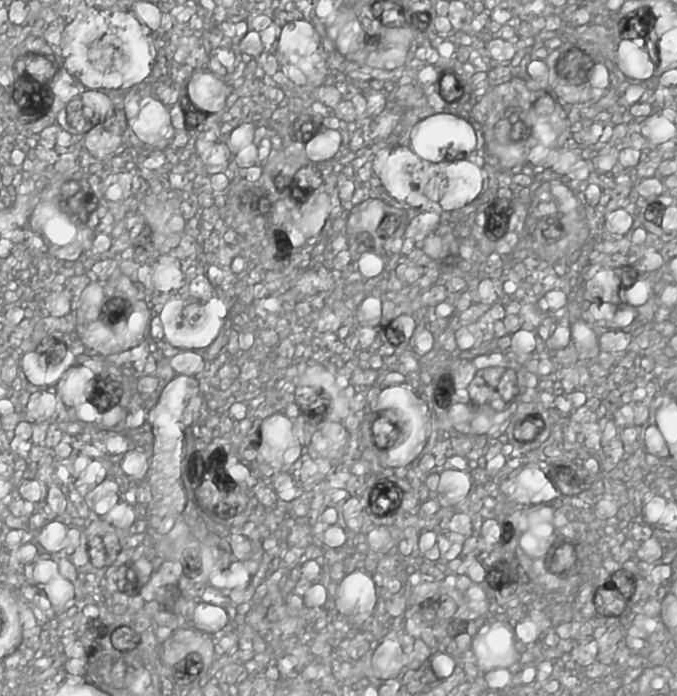

In [33]:
#image grayscale conversion
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(gray)


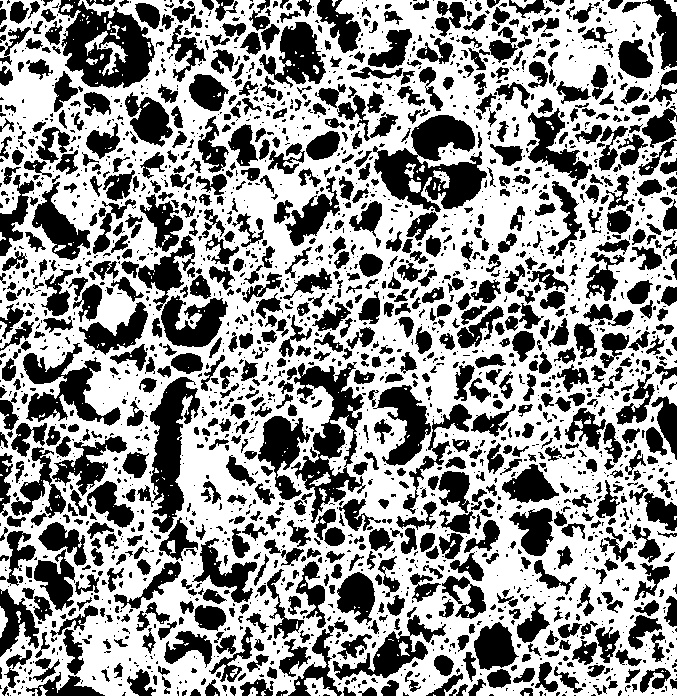

In [48]:
#Threshold Processing
ret, bin_img = cv2.threshold(gray,
                            0, 255, 
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
imshow(bin_img)


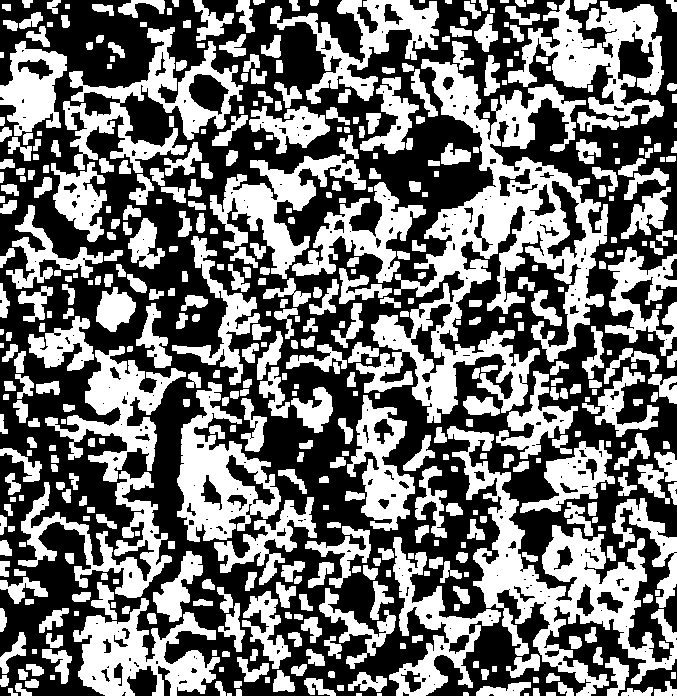

In [35]:
# noise removal
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img = cv2.morphologyEx(bin_img, 
                        cv2.MORPH_OPEN,
                        kernel,
                        iterations=2)
imshow(bin_img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


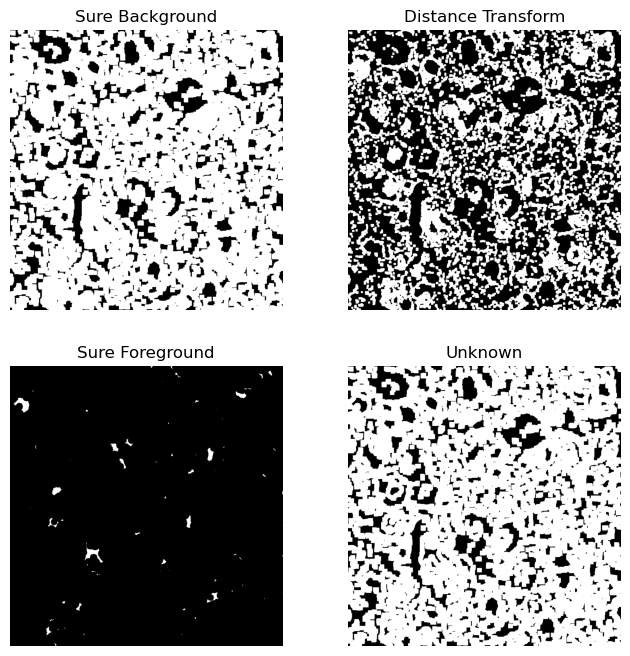

In [36]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# sure background area
sure_bg = cv2.dilate(bin_img, kernel, iterations=3)
imshow(sure_bg, axes[0,0])
axes[0, 0].set_title('Sure Background')

# Distance transform
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
imshow(dist, axes[0,1])
axes[0, 1].set_title('Distance Transform')

#foreground area
ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8) 
imshow(sure_fg, axes[1,0])
axes[1, 0].set_title('Sure Foreground')

# unknown area
unknown = cv2.subtract(sure_bg, sure_fg)
imshow(unknown, axes[1,1])
axes[1, 1].set_title('Unknown')

plt.show()


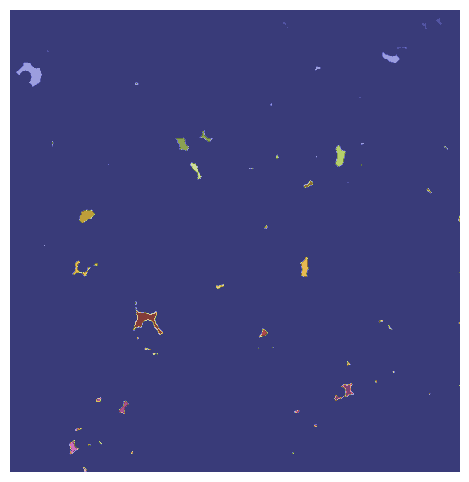

In [37]:
# Marker labelling
# sure foreground 
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that background is not 0, but 1
markers += 1
# mark the region of unknown with zero
markers[unknown == 255] = 0

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()


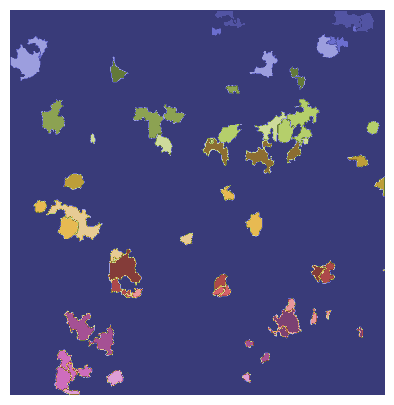

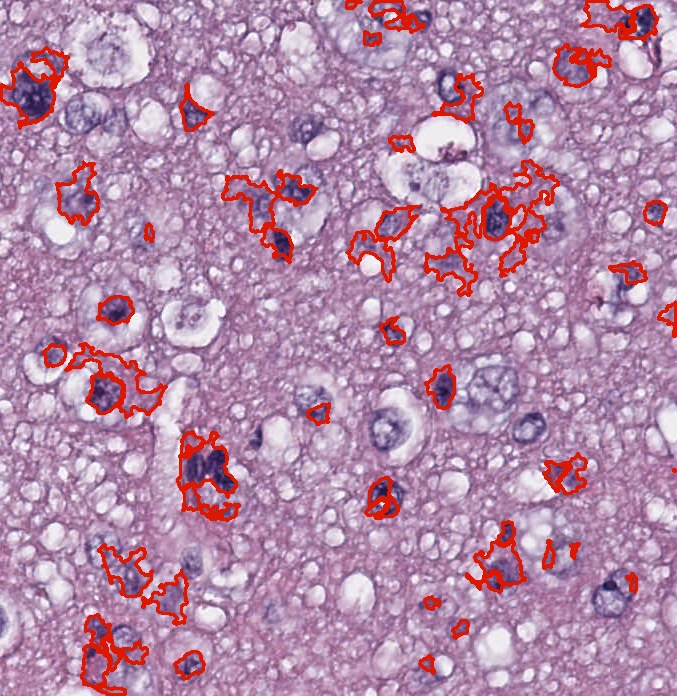

In [49]:
# watershed Algorithm
markers = cv2.watershed(img, markers)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()


labels = np.unique(markers)

coins = []
for label in labels[2:]: 

# Create a binary image in which only the area of the label is in the foreground 
#and the rest of the image is in the background 
    target = np.where(markers == label, 255, 0).astype(np.uint8)

# Perform contour extraction on the created binary image
    contours, hierarchy = cv2.findContours(
        target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    coins.append(contours[0])

# Draw the outline
img = cv2.drawContours(img, coins, -1, color=(0, 23, 223), thickness=2)
imshow(img)


Other approaches and research papers


https://www.nature.com/articles/s41597-020-0528-1


https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0273682


https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5478972/        

In [50]:
pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/58/70/e8ac764ec80810eefcbab0cb1d21dbba6cf26719c44cd6d9a5e9f0407935/tensorflow-2.16.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/41/f0/7e988a019bc54b2dbd0ad4182ef2d53488bb02e58694cd79d61369e85900/flatbuffers-24.3.25-py2.py3-none-any.whl.metadata
  Obtaining dependency informa

  Obtaining dependency information for tensorboard-data-server<0.8.0,>=0.7.0 from https://files.pythonhosted.org/packages/73/c6/825dab04195756cf8ff2e12698f22513b3db2f64925bdd41671bfb33aaa5/tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 6.3 MB/s eta 0:00:000m eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 20.9 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 21.5 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.5 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 15.9 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.7 MB/s eta 0:00:00 MB/s eta 0:0

### CNN MODEL

In [106]:
import tensorflow as tf
import pandas as pd 
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt 
import os 
import pathlib 
import random

In [107]:
path = '/home/snucse/Desktop/Inbreast Dataset'
data_dir = pathlib.Path(path)

In [108]:
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['Benign', 'Malignant'], dtype='<U9')

In [114]:
benignPath = os.path.join(data_dir,'Benign')
malignantPath = os.path.join(data_dir,'Malignant')

In [115]:
imageCount = len(list(data_dir.glob('*/*.png')))
imageCount

0

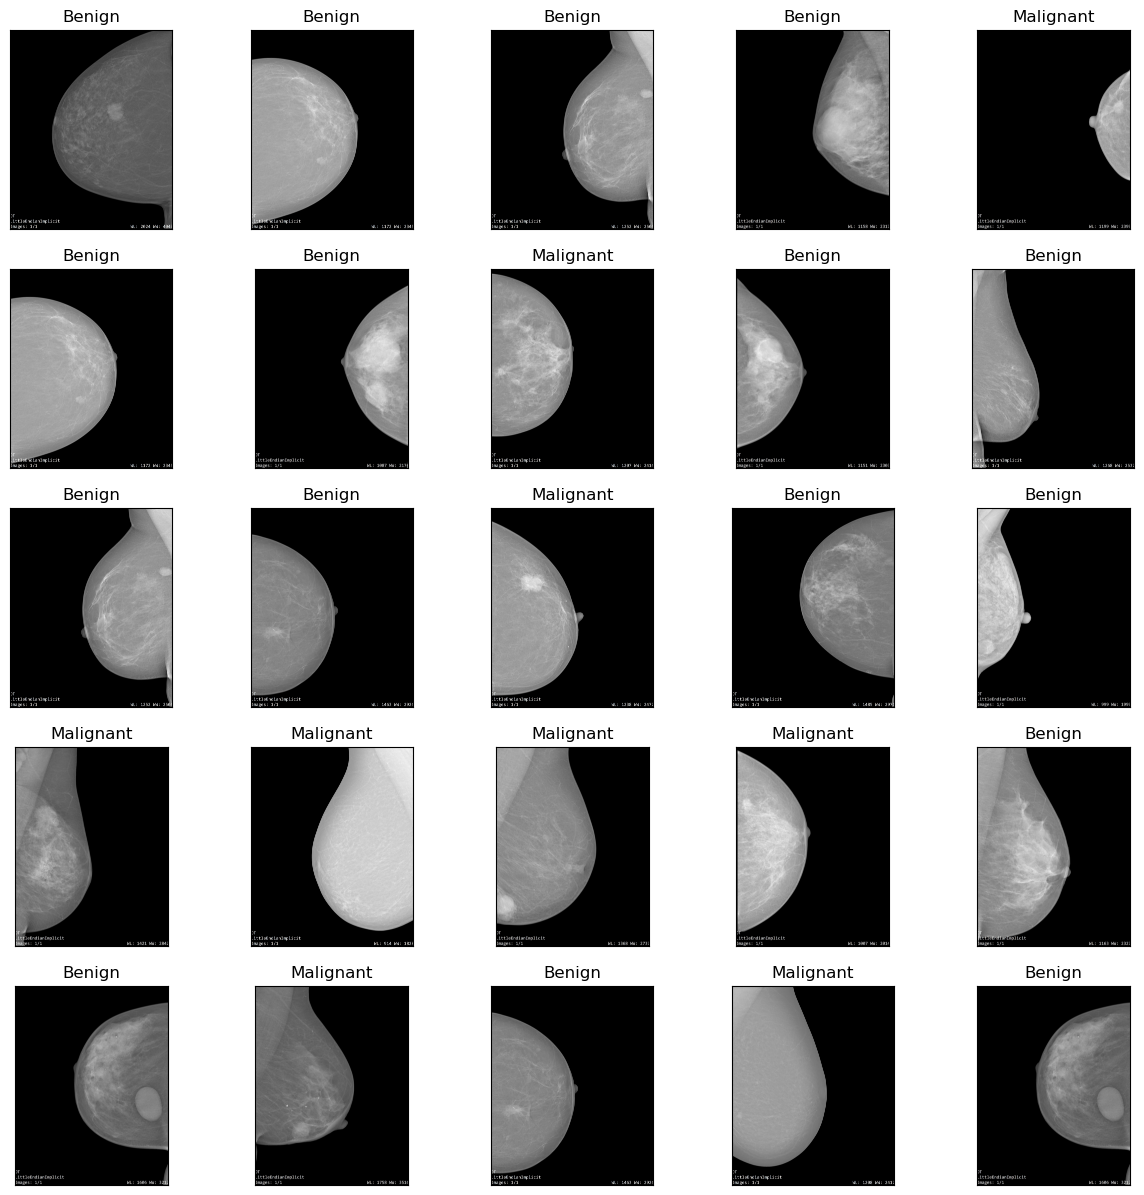

In [117]:
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    random_class = random.choice(class_names)
    img = plt.imread(random.choice(list(data_dir.glob(random_class+"/*.jpg"))))
    plt.xticks([])
    plt.yticks([])
    plt.title(random_class)
    plt.imshow(img)

In [120]:
imageCount = len(list(data_dir.glob('*/*.jpg')))
imageCount


108

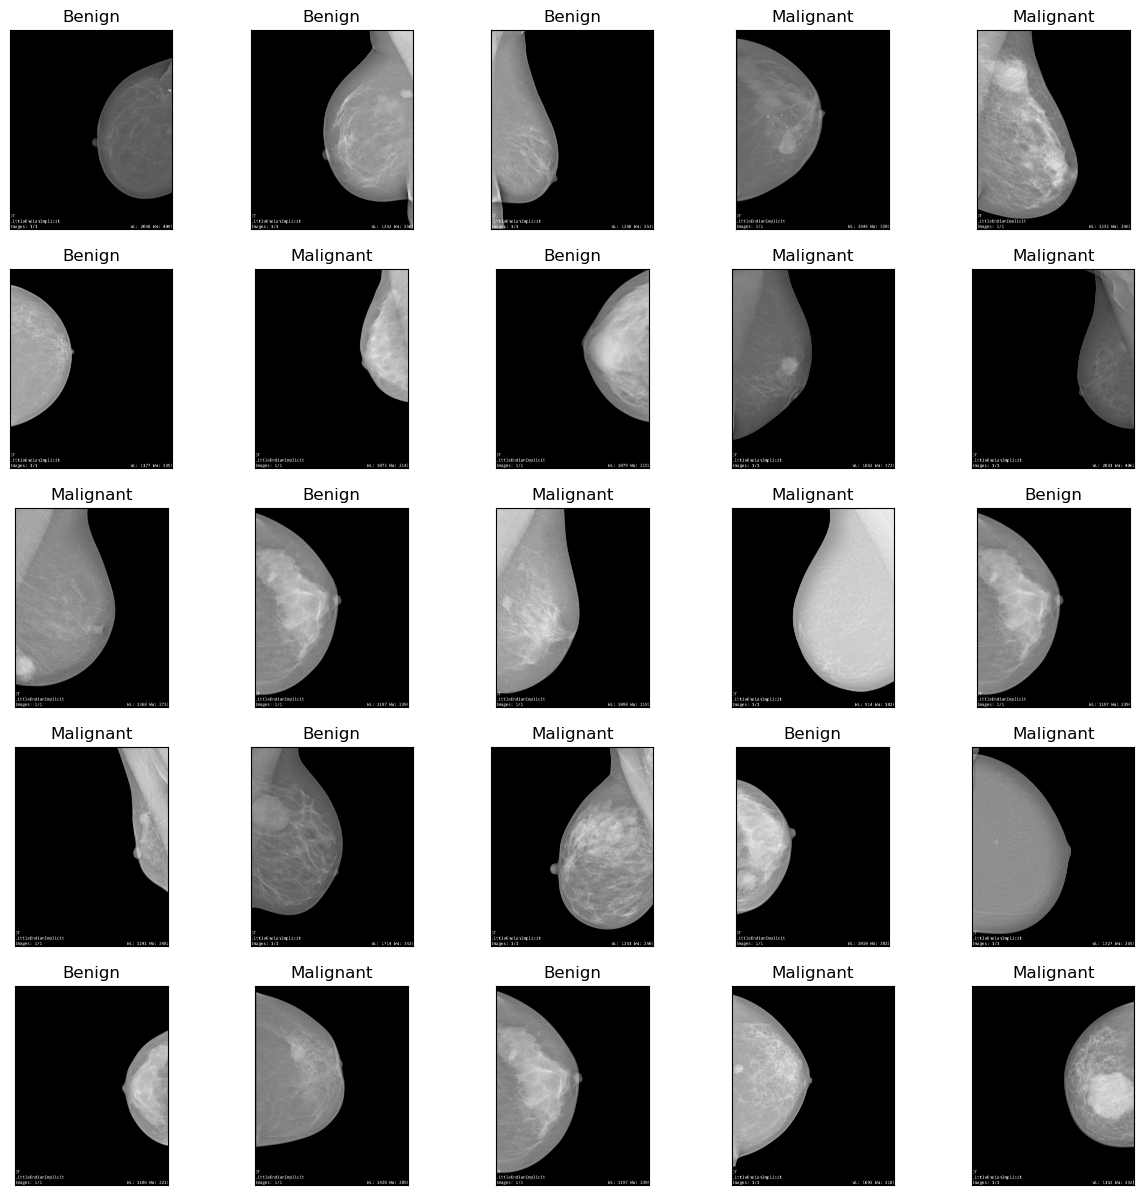

In [122]:
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    random_class = random.choice(class_names)
    img = plt.imread(random.choice(list(data_dir.glob(random_class+"/*.jpg"))))
    plt.xticks([])
    plt.yticks([])
    plt.title(random_class)
    plt.imshow(img)

In [126]:
from pathlib import Path
import imghdr

data_dir = '/home/snucse/Desktop/Inbreast Dataset'
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [127]:
batch_size = 32
img_height = 224
img_width = 224

In [128]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data = image_dataset_from_directory(
                  data_dir,
                  validation_split=0.2,
                  subset="training",
                  seed=123,
                  image_size=(img_height, img_width),
                  batch_size=batch_size)


val_data = image_dataset_from_directory(data_dir,
                                        validation_split=0.2,
                                        subset="validation",
                                        seed=123,
                                        image_size=(img_height,img_width),
                                        batch_size=batch_size)


Found 108 files belonging to 2 classes.
Using 87 files for training.
Found 108 files belonging to 2 classes.
Using 21 files for validation.


In [129]:
from tensorflow.keras import layers 
model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(3,activation="softmax")
])

/home/snucse/.local/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [130]:
model.compile(optimizer="Adam",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"])


In [131]:
epochs = 2
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data=val_data, 
                    batch_size=batch_size)


Epoch 1/2


/home/snucse/.local/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:625: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.3089 - loss: 1.1553 - val_accuracy: 0.3810 - val_loss: 1.5534
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.6867 - loss: 0.6860 - val_accuracy: 0.8095 - val_loss: 0.4798


In [132]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

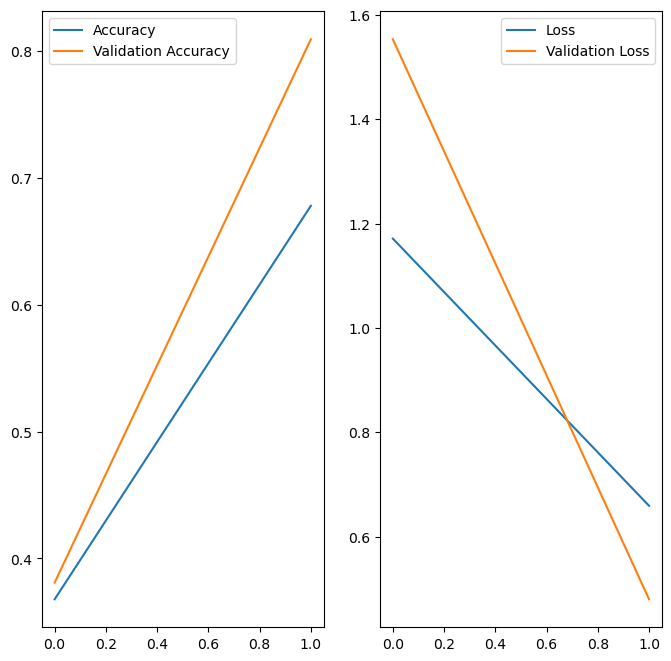

In [133]:
acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy')
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Loss')
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.legend()
plt.show()


In [134]:
model.evaluate(val_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8095 - loss: 0.4798


[0.47978585958480835, 0.8095238208770752]

### ANN MODEL

In [104]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.math import confusion_matrix
import seaborn as sns
tf.random.set_seed(3)


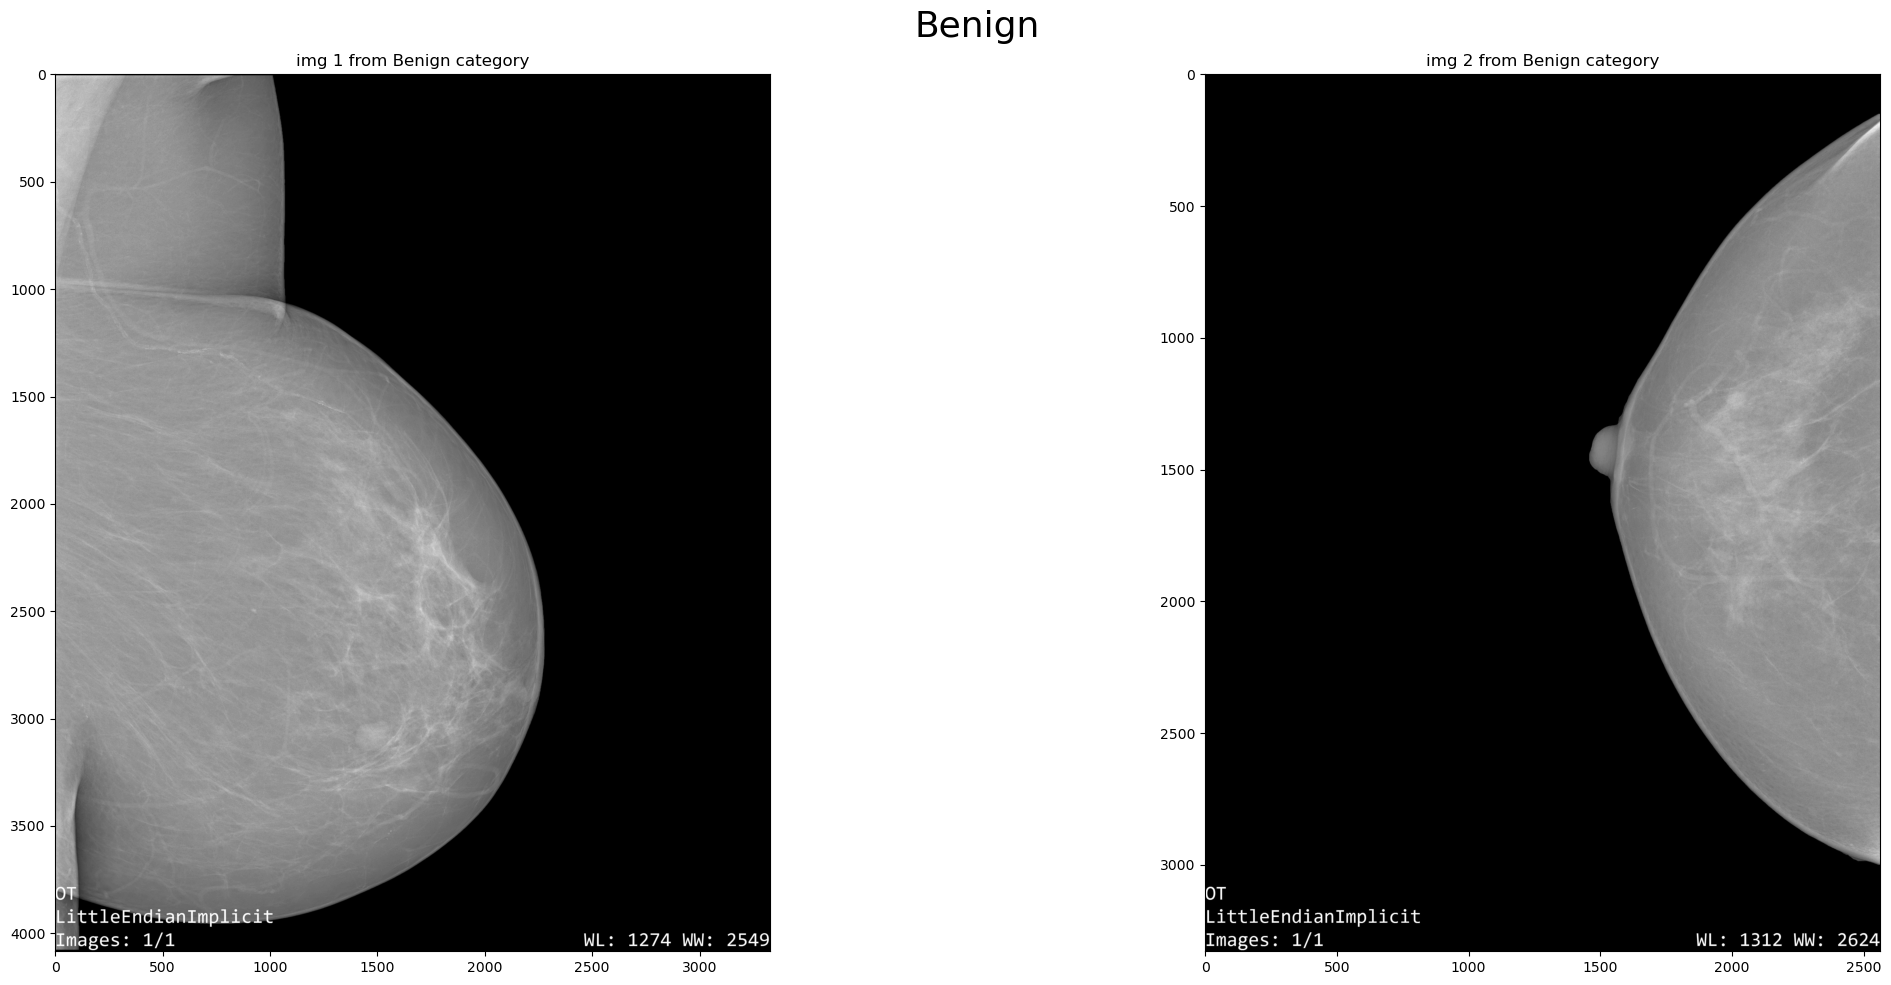

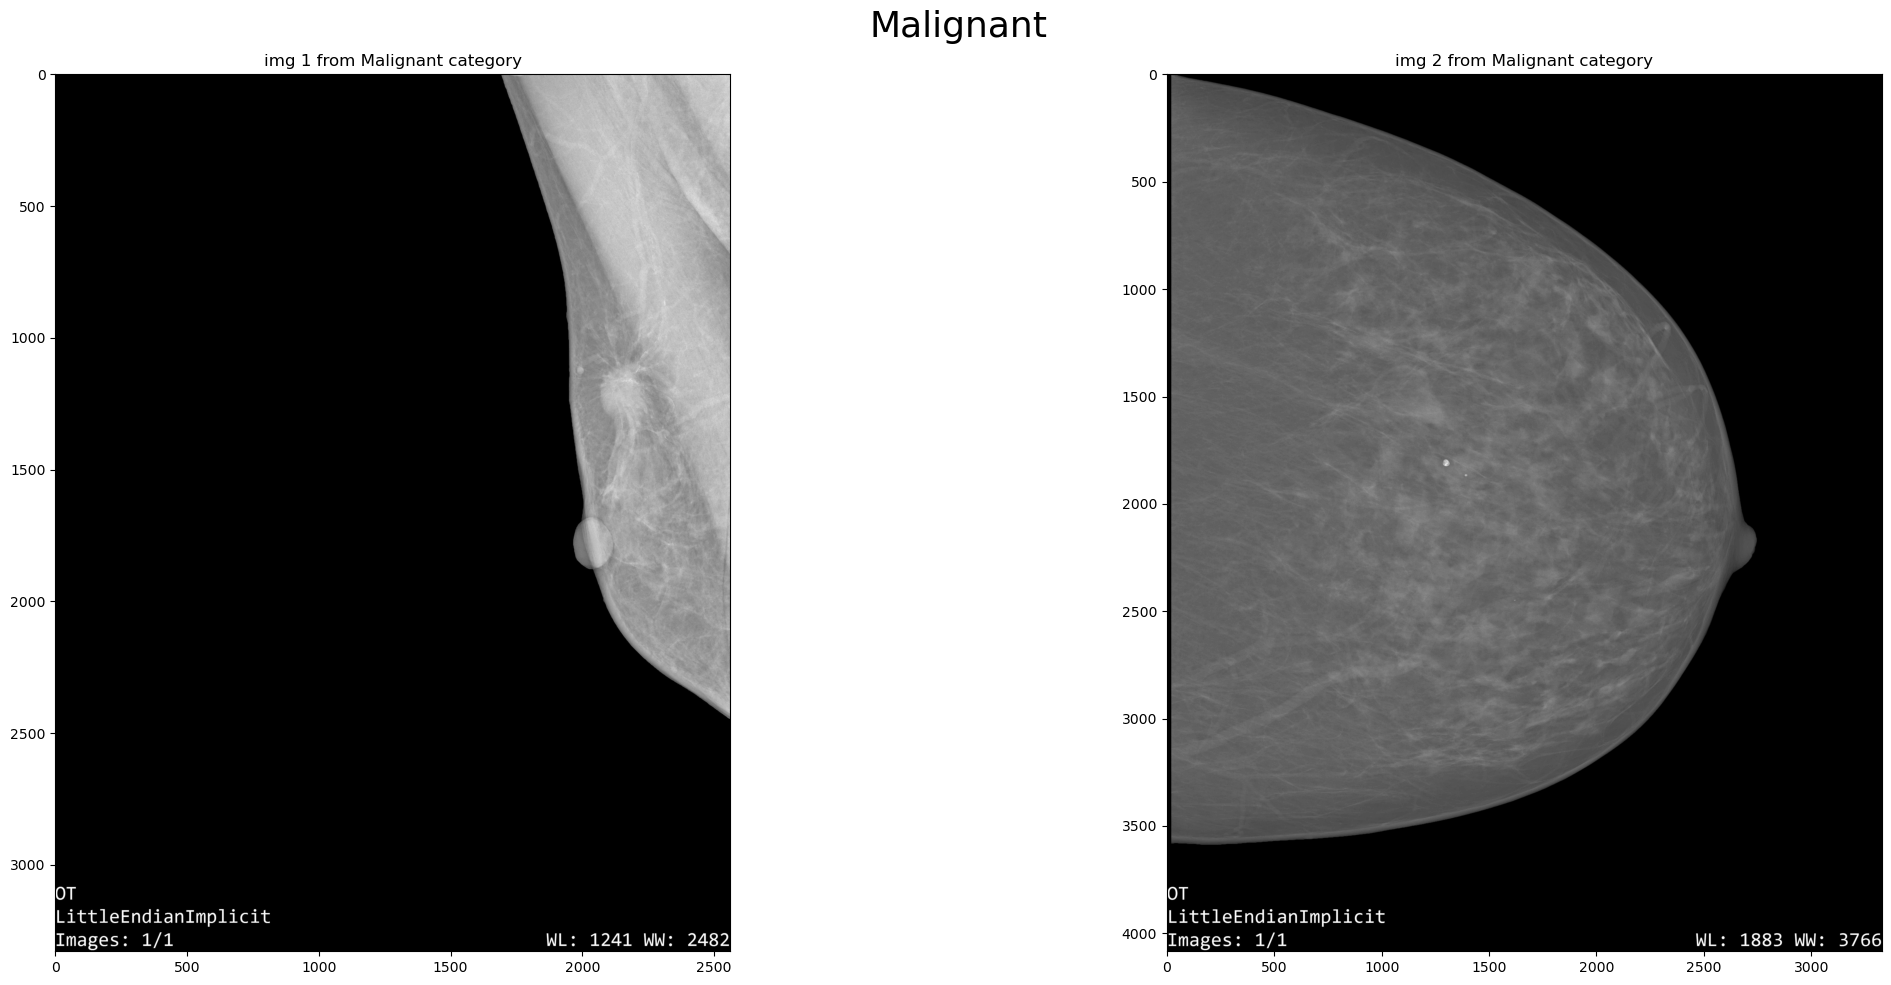

In [105]:
folder_name = '/home/snucse/Desktop/Inbreast Dataset'
files_names = ['Benign', 'Malignant']

for file in files_names:
    path = os.path.join(folder_name, file)
    x = 0
    fig, axes = plt.subplots(1,2, figsize=(25, 10))  
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        axes[x].imshow(img_array, cmap='gray')
        axes[x].set_title(f"img {x+1} from {file} category")
        x += 1
        if x == 2: 
            break

    plt.suptitle(file, fontsize=26)
    plt.tight_layout()
    plt.show()



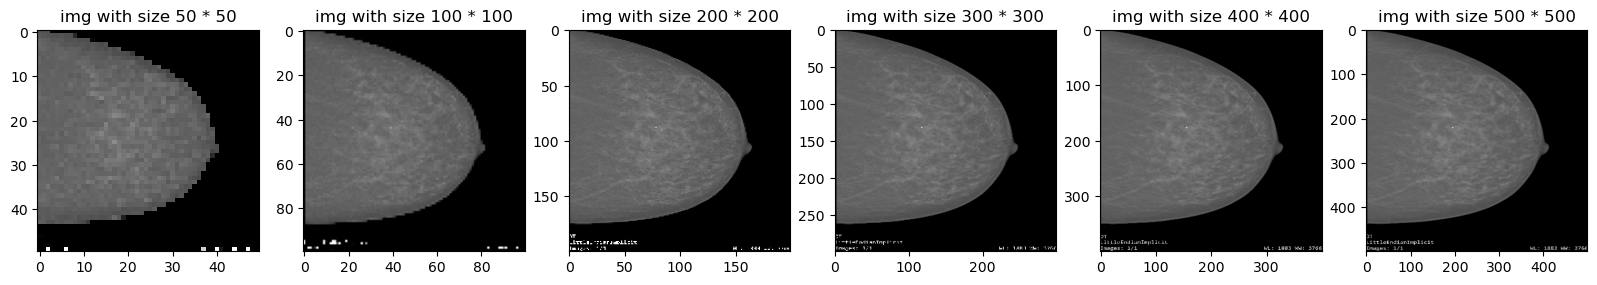

In [57]:
img_sz = [50, 100, 200, 300, 400, 500]
plt.figure(figsize=(20, 5))

for i, sz in enumerate(img_sz):
    new_array = cv2.resize(img_array, (sz, sz))
    plt.subplot(1, len(img_sz), i+1)
    plt.imshow(new_array, cmap='gray')
    plt.title(f"img with size {sz} * {sz}")

plt.show()

In [58]:
img_sz=300

In [59]:
training_data = []

def create_training_data():
    for file in files_names:
        path = os.path.join(folder_name, file)
        class_num = files_names.index(file)
        print(file,class_num)
        
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (img_sz, img_sz))  # Include resizing
            training_data.append([new_array, class_num])

create_training_data()


Benign 0


100%|███████████████████████████████████████████| 37/37 [00:00<00:00, 64.51it/s]


Malignant 1


100%|███████████████████████████████████████████| 71/71 [00:01<00:00, 61.35it/s]


In [60]:
for i in range(5):
    print("Class number for image", i+1, ":", training_data[i][1])


Class number for image 1 : 0
Class number for image 2 : 0
Class number for image 3 : 0
Class number for image 4 : 0
Class number for image 5 : 0


In [61]:
for i in range(-1, -6, -1):
    print("Class number for image", len(training_data) + i + 1, ":", training_data[i][1])

Class number for image 108 : 1
Class number for image 107 : 1
Class number for image 106 : 1
Class number for image 105 : 1
Class number for image 104 : 1


In [62]:
random.shuffle(training_data)

for i in range(30):
    print(f"Sample {i+1}:")
    print("Class number:", training_data[i][1],"\n") 

Sample 1:
Class number: 0 

Sample 2:
Class number: 1 

Sample 3:
Class number: 0 

Sample 4:
Class number: 1 

Sample 5:
Class number: 0 

Sample 6:
Class number: 1 

Sample 7:
Class number: 1 

Sample 8:
Class number: 1 

Sample 9:
Class number: 0 

Sample 10:
Class number: 1 

Sample 11:
Class number: 1 

Sample 12:
Class number: 0 

Sample 13:
Class number: 1 

Sample 14:
Class number: 1 

Sample 15:
Class number: 1 

Sample 16:
Class number: 0 

Sample 17:
Class number: 1 

Sample 18:
Class number: 1 

Sample 19:
Class number: 1 

Sample 20:
Class number: 0 

Sample 21:
Class number: 0 

Sample 22:
Class number: 1 

Sample 23:
Class number: 1 

Sample 24:
Class number: 0 

Sample 25:
Class number: 1 

Sample 26:
Class number: 1 

Sample 27:
Class number: 1 

Sample 28:
Class number: 1 

Sample 29:
Class number: 1 

Sample 30:
Class number: 0 



In [63]:
X=[]
y=[]

for feature,label in training_data:
    X.append(feature)
    y.append(label)


X=np.array(X)
y=np.array(y)

In [64]:
X=np.array(X)
y=np.array(y)
print(X.shape)
print(y.shape)

(108, 300, 300)
(108,)


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(86, 300, 300)
(86,)
(22, 300, 300)
(22,)


In [66]:
print(np.unique(y_train))
print(np.unique(y_test))

[0 1]
[0 1]


In [67]:
X_train = X_train/255
X_test = X_test/255

In [68]:
print(X_train[0])


[[0.52156863 0.51372549 0.51764706 ... 0.         0.         0.        ]
 [0.5254902  0.54509804 0.5254902  ... 0.         0.         0.        ]
 [0.54117647 0.56078431 0.51372549 ... 0.         0.         0.        ]
 ...
 [0.47058824 0.45490196 0.98823529 ... 0.         0.         0.01176471]
 [0.47058824 0.47058824 0.45098039 ... 0.         0.         0.00784314]
 [0.4627451  0.43137255 0.43529412 ... 0.         0.         0.        ]]


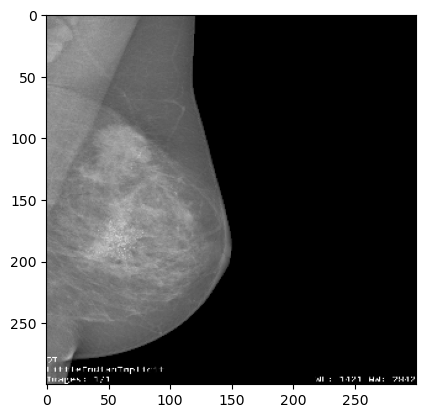

In [69]:
plt.imshow(X_train[0],cmap='gray')
plt.show()


In [93]:
model = keras.Sequential([
                          keras.layers.Flatten(input_shape=(img_sz,img_sz)),
                          keras.layers.Dense(256, activation='relu'),
                          keras.layers.Dense(128, activation='relu'),
                          keras.layers.Dense(64, activation='relu'),
                          keras.layers.Dense(32, activation='relu'),
                          keras.layers.Dense(16, activation='relu'),
                          keras.layers.Dense(8, activation='relu'),
                          keras.layers.Dense(3, activation='sigmoid')
])


/home/snucse/.local/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [94]:
model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [95]:
history=model.fit(X_train, y_train, epochs=20,validation_split=0.1)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.5747 - loss: 6.4415 - val_accuracy: 0.5556 - val_loss: 5.3826
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.5176 - loss: 5.4432 - val_accuracy: 0.6667 - val_loss: 3.6942
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.6346 - loss: 4.9742 - val_accuracy: 0.6667 - val_loss: 0.9718
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.6464 - loss: 1.1540 - val_accuracy: 0.4444 - val_loss: 1.2883
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.4954 - loss: 0.9314 - val_accuracy: 0.4444 - val_loss: 1.4185
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.5240 - loss: 0.8502 - val_accuracy: 0.8889 - val_loss: 1.1214
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.7776 - loss: 0.6374 - val_accuracy: 0.6667 - val_loss: 1.9720
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.7828 - loss: 0.8330 - val_accuracy: 0.6667 - val_loss:

In [96]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 90000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │    23,040,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,226,139 (264.08 MB)

 Trainable params: 23,075,379 (88.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,150,760 (176.05 MB)

In [97]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuarcy of the model is : {accuracy*100:.2f} %")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3636 - loss: 3.6359
Accuarcy of the model is : 36.36 %


In [98]:
y_pred=model.predict(X_test)
print(y_pred[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[9.9948782e-01 3.7594003e-04 6.5699030e-24]


In [99]:
y_pred = [np.argmax(i) for i in y_pred]
print(y_pred)


[0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0]


In [100]:
comparison_df = pd.DataFrame({ 'Actual': y_test,'Predicted': y_pred})

print(comparison_df[:20])

    Actual  Predicted
0        1          0
1        1          1
2        0          0
3        0          1
4        1          0
5        0          1
6        0          1
7        1          0
8        1          1
9        0          1
10       1          1
11       1          0
12       0          1
13       0          0
14       1          0
15       1          1
16       1          1
17       0          0
18       1          0
19       1          0


In [101]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

tf.Tensor(
[[3 5]
 [9 5]], shape=(2, 2), dtype=int32)


Text(0.5, 47.7222222222222, 'Predicted Labels')

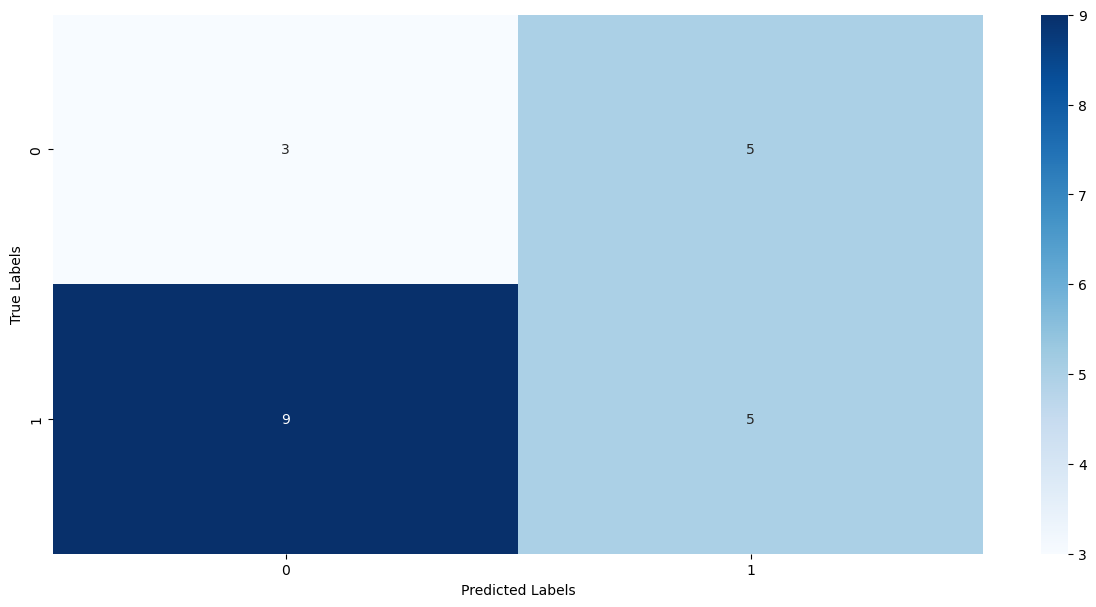

In [102]:
plt.figure(figsize=(15,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

In [103]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))



              precision    recall  f1-score   support

           0       0.25      0.38      0.30         8
           1       0.50      0.36      0.42        14

    accuracy                           0.36        22
   macro avg       0.38      0.37      0.36        22
weighted avg       0.41      0.36      0.37        22



### ML MODEL

In [141]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input


# Function to load images from a directory
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

# Load benign images
benign_images = load_images_from_folder('/home/snucse/Desktop/Inbreast Dataset/Benign')

# Load malignant images
malignant_images = load_images_from_folder('/home/snucse/Desktop/Inbreast Dataset/Malignant')
# Create labels (0 for benign, 1 for malignant)
labels = [0] * len(benign_images) + [1] * len(malignant_images)

# Concatenate images
images = benign_images + malignant_images

# Resize images to a fixed size (you may need to adjust this depending on your images)
resized_images = [cv2.resize(img, (100, 100)) for img in images]

# Convert images to numpy array
X = np.array(resized_images)

# Normalize pixel values
X = X / 255.0

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Machine Learning Model (Random Forest Classifier)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train.reshape(X_train.shape[0], -1), y_train)
y_pred_rf = rf_classifier.predict(X_test.reshape(X_test.shape[0], -1))

# Deep Learning Model (Convolutional Neural Network)

In [142]:
# Evaluate models
print("Machine Learning Model (Random Forest Classifier) Metrics:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Machine Learning Model (Random Forest Classifier) Metrics:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.70      1.00      0.82        14

    accuracy                           0.73        22
   macro avg       0.85      0.62      0.61        22
weighted avg       0.81      0.73      0.67        22

Accuracy: 0.7272727272727273
